In [575]:
# Importing all the neccessary libraries
import pandas as pd
import numpy as np
import time
import datetime

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

#Processors
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

#Regression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR

#Performance
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

#define gloabal color palette
color = cm.inferno_r(np.linspace(.3, .8, 5))
colorSet2 = sns.color_palette(palette='Set2')
cmap = sns.cubehelix_palette(as_cmap=True, reverse=True)

### Business Understanding

In the Bay Area housing market, predicting house sale prices can be particularly challenging due to the phenomenon of houses selling for prices significantly above their asking prices. This trend is often driven by high demand, limited inventory, and competitive bidding among buyers. To build an accurate prediction model with the highest accuracy, it is crucial to consider a range of factors that can influence house prices.
    
Factors such as location, size, schools, ease of transit and recent sales data of similar properties in the area can have a significant impact on the sale price. By carefully analyzing these factors and understanding their relative importance, it is possible to develop an effective prediction model which in turns will boost the confidence of buyers for putting the right offer.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.
This specific dataset is being created with Redfin APIs. We filtered the data from Redfin for last 6 months sold property infromation in the Bay area. Combined into a CSV format with fetching additional inormation required with the APIs provided. 

You can find the data in the data folder named FinalRedfin.csv

In [576]:
# Data Collection --> This phase is done with loading FinalRedfin.csv data
houseDf = pd.read_csv("FinalRedfin.csv")
# Data Sample
houseDf.sample()

,Unnamed: 0,soldDate,propertyType,address,city,zipOrPostalCode,price,beds,baths,location,...,latitude,longitude,walkScore,bikeScore,transitScore,rentalValue,elementry,middle,high,listPrice
216,273,February-26-2024,Single Family Residential,1402 Mount Palomar Dr,San Jose,95127.00,905000.00,3.00,2.00,SAN JOSE,...,37.35,-121.81,58.00,57.00,37.00,3297.00,6.00,NaN,NaN,899999.00


In [577]:
# Data Description
houseDf.info()
numeric_features = houseDf.select_dtypes(include=['int64', 'float64']).columns
print(numeric_features)
categorical_features = houseDf.select_dtypes(include=['object']).columns
print(categorical_features)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2627 entries, 0 to 2626
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       2627 non-null   int64  
 1   soldDate         2627 non-null   object 
 2   propertyType     2627 non-null   object 
 3   address          2627 non-null   object 
 4   city             2627 non-null   object 
 5   zipOrPostalCode  2627 non-null   float64
 6   price            2627 non-null   float64
 7   beds             2627 non-null   float64
 8   baths            2627 non-null   float64
 9   location         2627 non-null   object 
 10  squareFeet       2627 non-null   float64
 11  lotSize          2627 non-null   float64
 12  yearBuilt        2627 non-null   float64
 13  ppsf             2627 non-null   float64
 14  latitude         2627 non-null   float64
 15  longitude        2627 non-null   float64
 16  walkScore        2251 non-null   float64
 17  bikeScore     

In [541]:
#Convert sold date into month and year format
houseDf["soldDate"] = pd.to_datetime(houseDf["soldDate"])
houseDf["soldDate"]  = houseDf["soldDate"].dt.to_period('M')

In [542]:
#Data Quality
houseDf.describe()

,Unnamed: 0,zipOrPostalCode,price,beds,baths,squareFeet,lotSize,yearBuilt,ppsf,latitude,longitude,walkScore,bikeScore,transitScore,rentalValue,elementry,middle,high,listPrice
count,2627.00,2627.00,2627.00,2627.00,2627.00,2627.00,2627.00,2627.00,2627.00,2627.00,2627.00,2251.00,2251.00,2251.00,2251.00,2251.00,2235.00,2226.00,2163.00
mean,1594.92,95120.02,1763929.18,3.52,2.28,1752.47,6835.68,1967.39,1079.24,37.29,-121.88,47.92,57.17,34.21,4155.19,5.44,5.24,7.02,1678189.02
std,911.54,25.95,584048.45,0.75,0.67,621.43,2802.75,20.20,777.44,0.05,0.06,20.47,16.70,13.45,1833.87,1.64,1.66,1.40,586230.27
min,1.00,95008.00,780000.00,1.00,1.00,100.00,1307.00,1900.00,457.00,37.21,-122.03,0.00,0.00,0.00,0.00,1.00,2.00,4.00,119800.00
25%,813.00,95119.00,1350000.00,3.00,2.00,1328.00,5663.00,1958.00,855.00,37.26,-121.93,32.00,49.00,27.00,3688.00,4.00,5.00,6.00,1298500.00
50%,1604.00,95124.00,1700000.00,3.00,2.00,1633.00,6168.00,1964.00,994.00,37.28,-121.89,51.00,59.00,37.00,4248.00,6.00,5.00,7.00,1588000.00
75%,2381.50,95129.00,2135000.00,4.00,2.50,2009.00,7405.00,1976.00,1185.00,37.32,-121.84,64.00,69.00,45.00,4960.00,6.00,6.00,8.00,1975000.00
max,3158.00,95211.00,4500000.00,6.00,5.50,6199.00,29185.00,2023.00,13500.00,37.42,-121.74,92.00,96.00,66.00,10443.00,9.00,8.00,9.00,4500000.00


In [543]:
#Find duplicates if any
duplicates = houseDf.duplicated().sum()
print("----------------------------")
print(f"Duplicate values in vehicle dataset: {duplicates}")

----------------------------
Duplicate values in vehicle dataset: 0


### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [544]:
#Remove unneccessry columns
columnList = [ 'address', 'propertyType', 'latitude', 'longitude', "Unnamed: 0", "city"]
newHouseDf = houseDf.drop(columnList, axis=1)
newHouseDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2627 entries, 0 to 2626
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype    
---  ------           --------------  -----    
 0   soldDate         2627 non-null   period[M]
 1   zipOrPostalCode  2627 non-null   float64  
 2   price            2627 non-null   float64  
 3   beds             2627 non-null   float64  
 4   baths            2627 non-null   float64  
 5   location         2627 non-null   object   
 6   squareFeet       2627 non-null   float64  
 7   lotSize          2627 non-null   float64  
 8   yearBuilt        2627 non-null   float64  
 9   ppsf             2627 non-null   float64  
 10  walkScore        2251 non-null   float64  
 11  bikeScore        2251 non-null   float64  
 12  transitScore     2251 non-null   float64  
 13  rentalValue      2251 non-null   float64  
 14  elementry        2251 non-null   float64  
 15  middle           2235 non-null   float64  
 16  high             2226 no

In [545]:
#Drop any empty data fields
newHouseDf = newHouseDf.dropna()

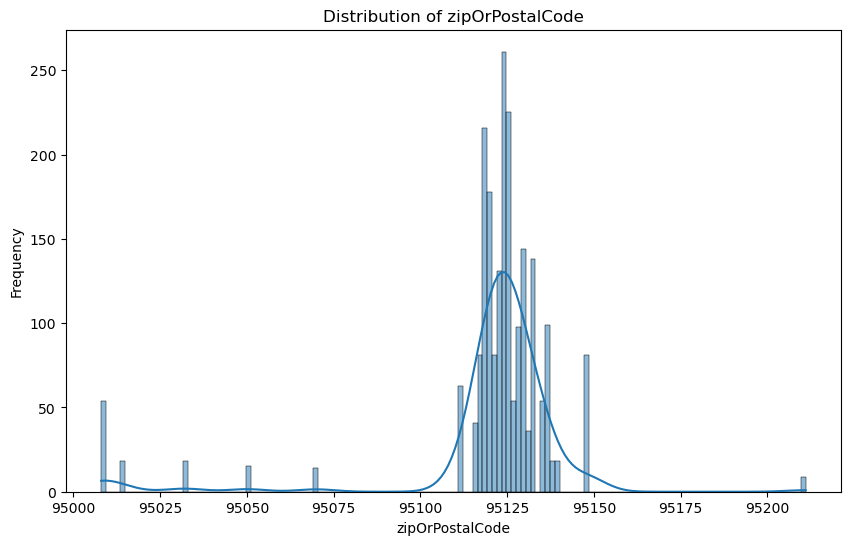

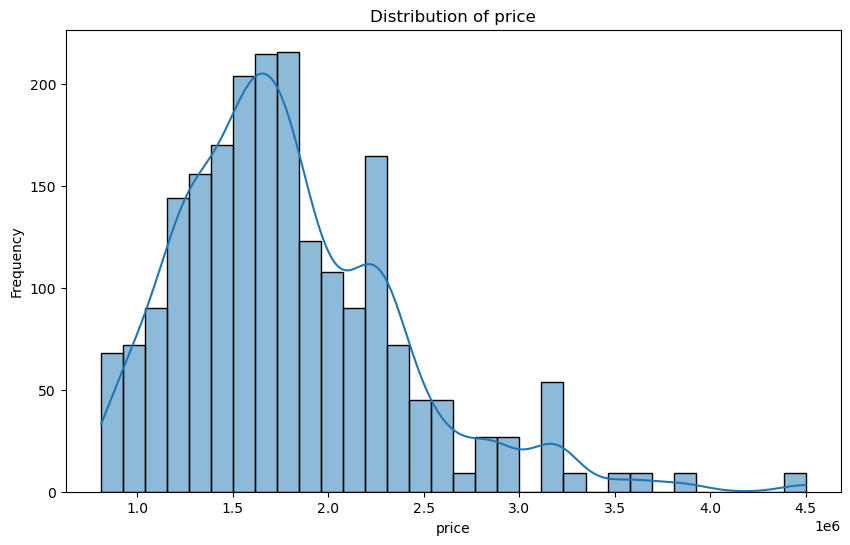

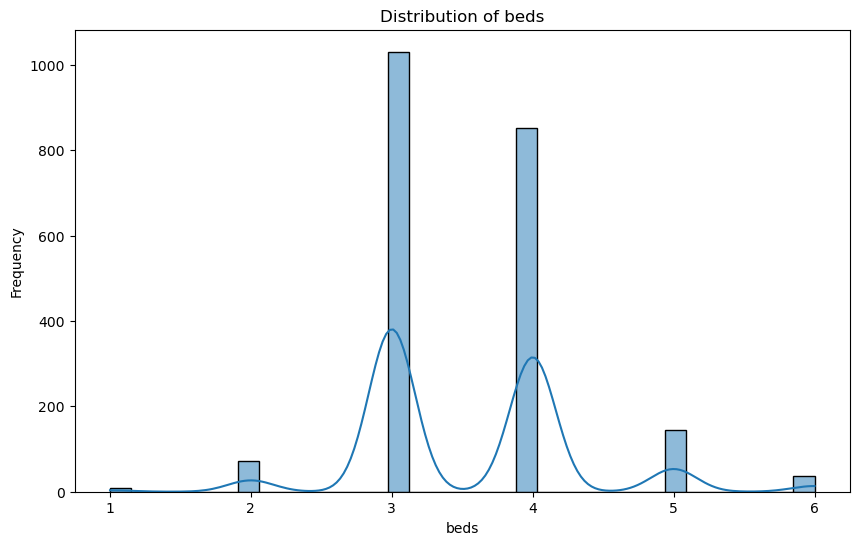

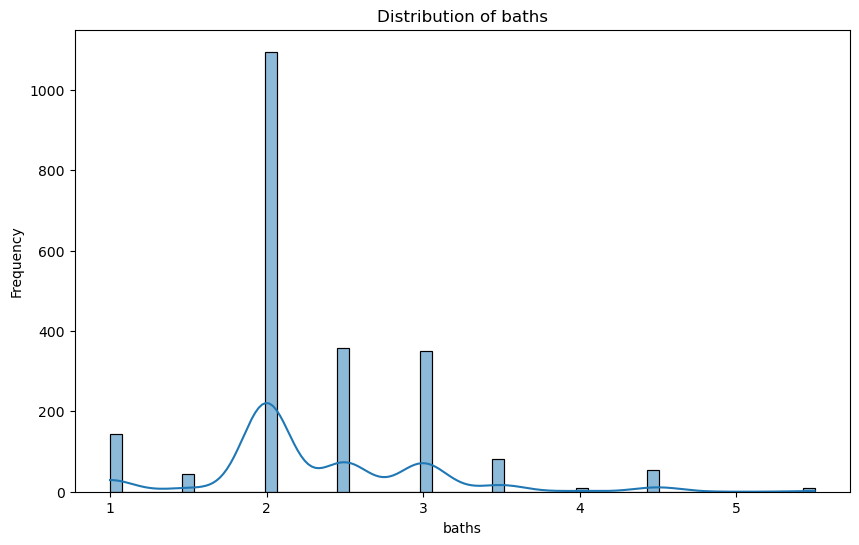

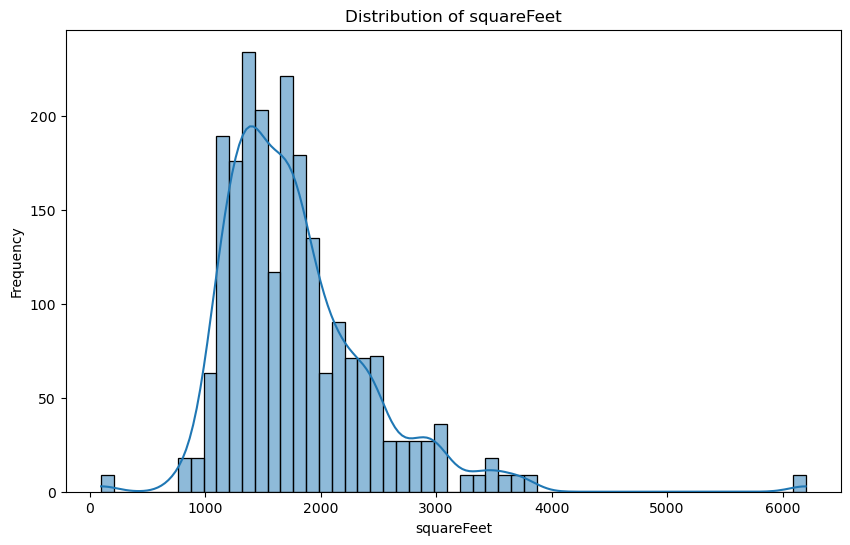

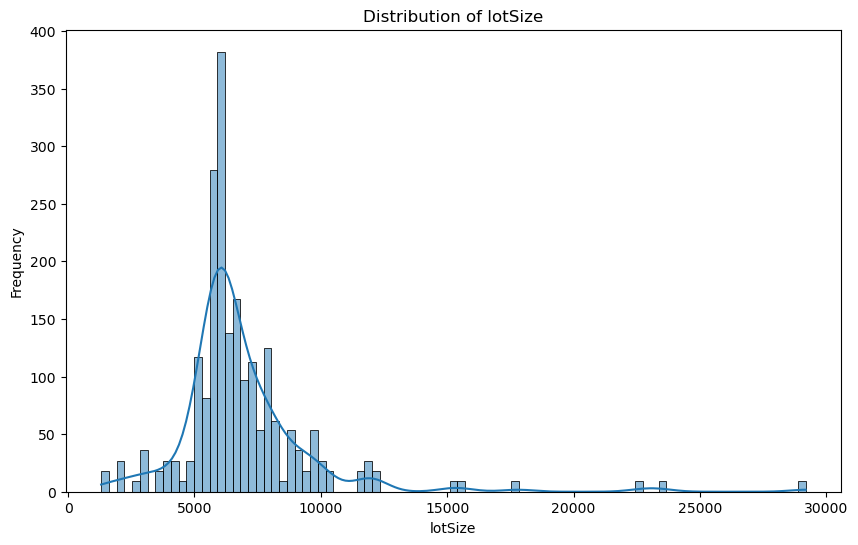

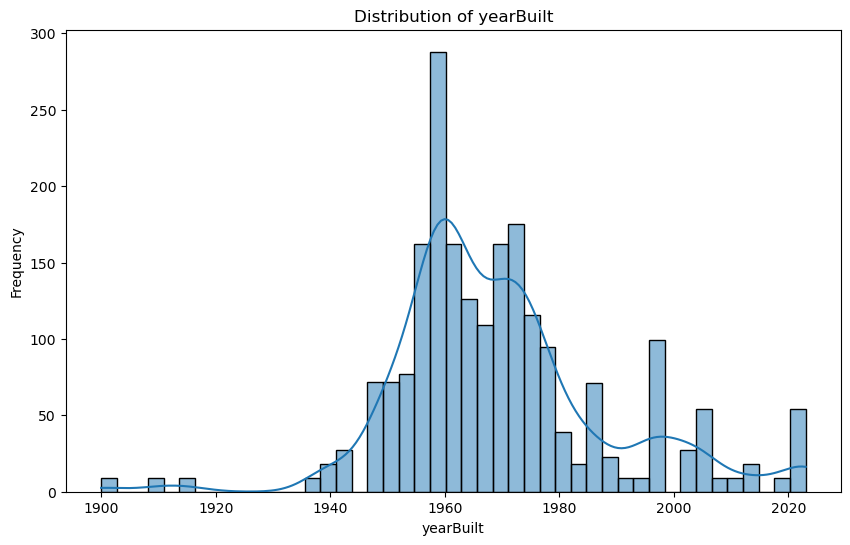

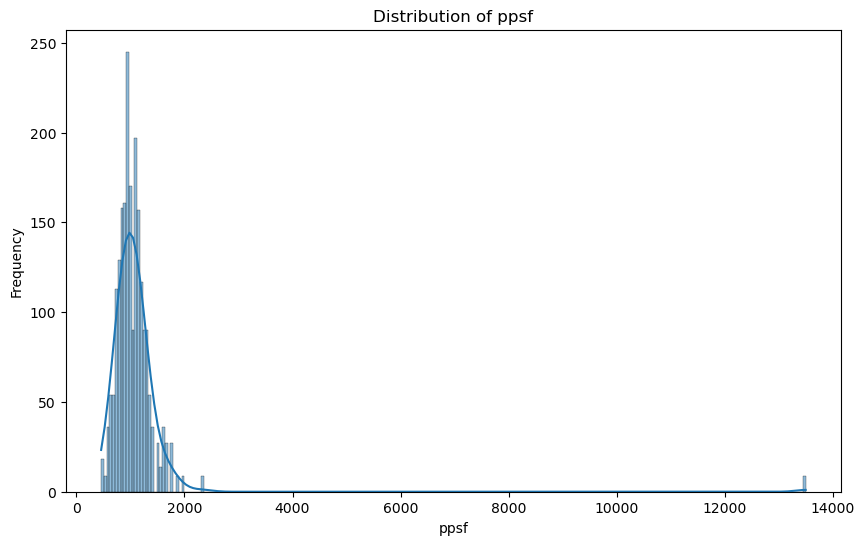

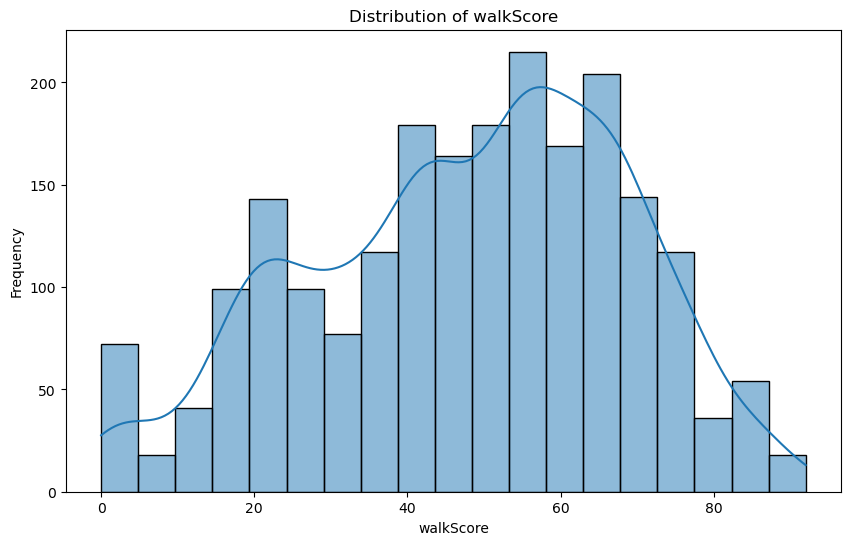

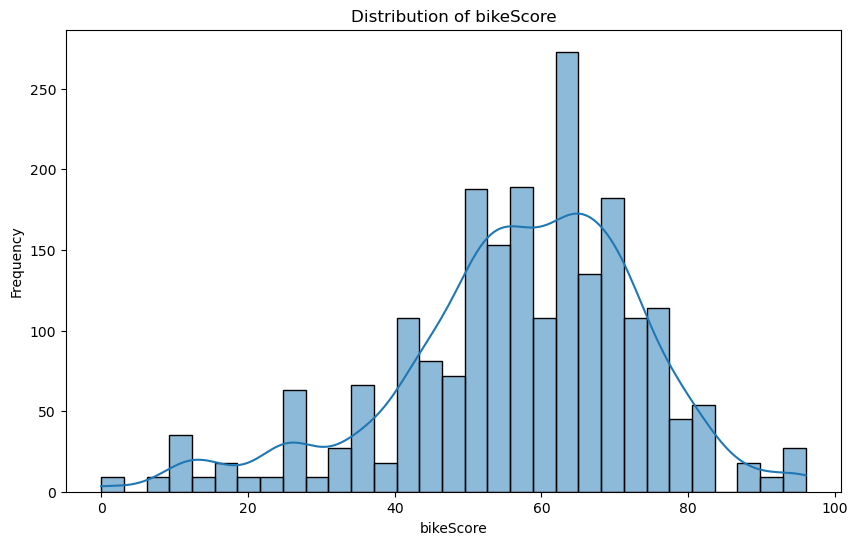

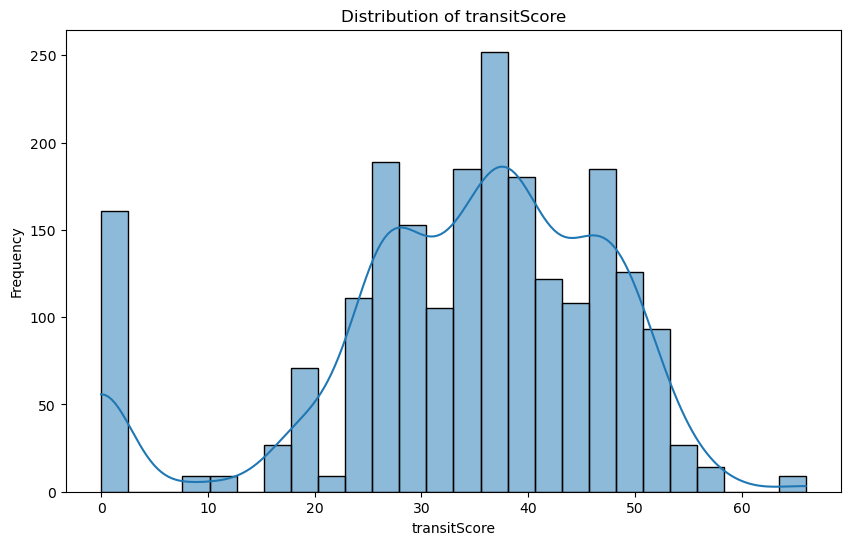

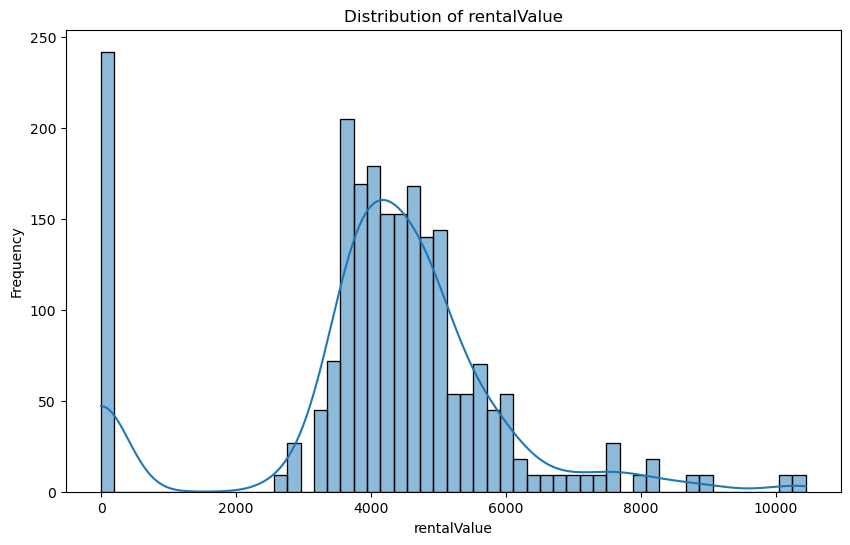

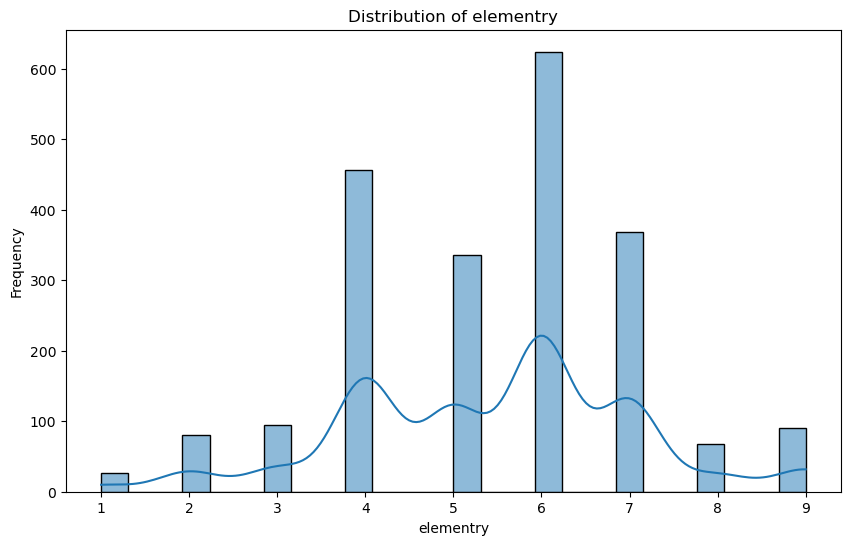

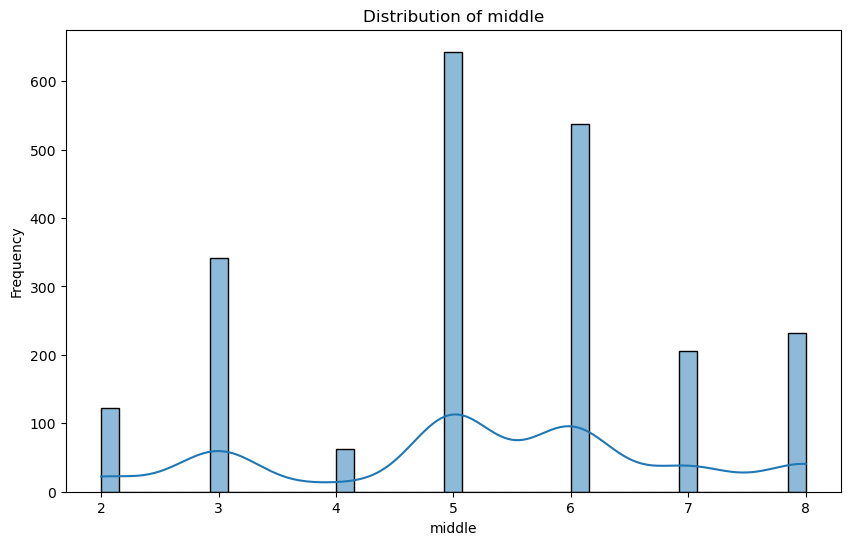

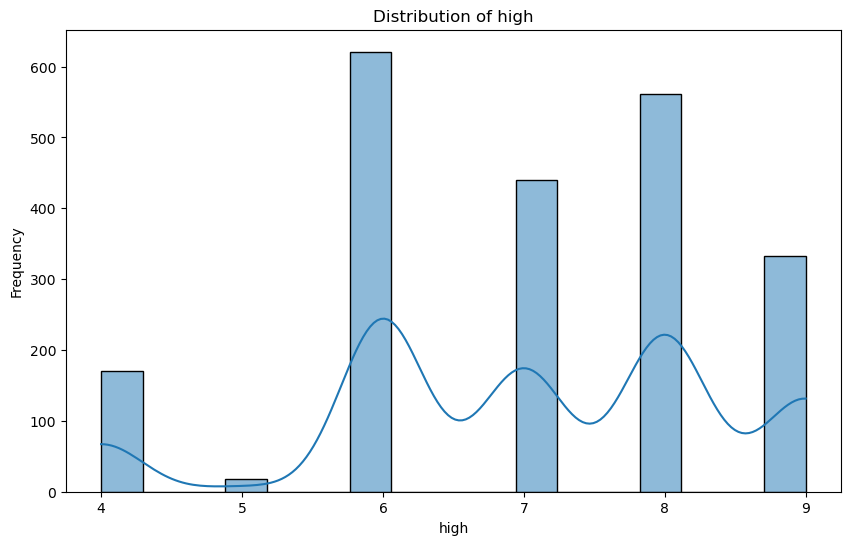

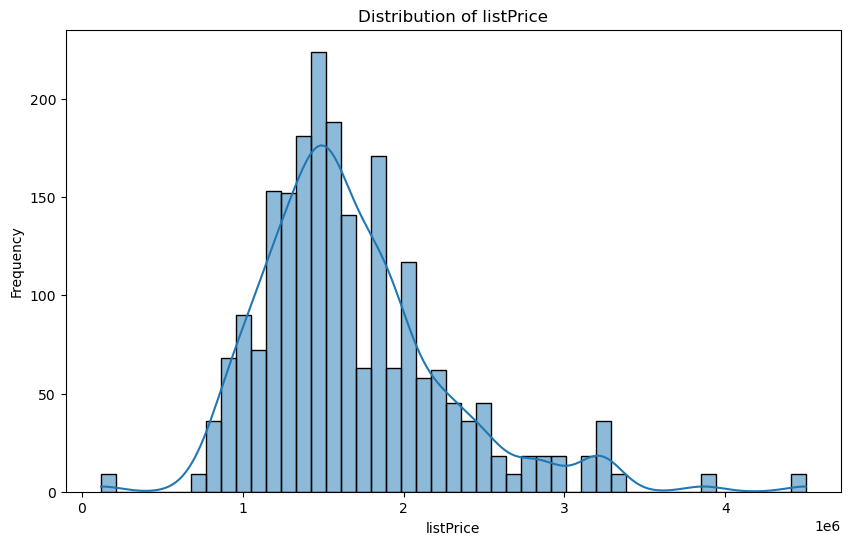

In [546]:
#Plot distibution of all numeric data to understand the distribution
for column in newHouseDf.columns:
    if newHouseDf[column].dtype == 'float64':
        # Lets see how the House prices are distributed
        plt.figure(figsize=(10, 6))
        sns.histplot(newHouseDf[column], kde=True)
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.show()

In [547]:
# Remove outliers in price, Rental, transitScore, lotSize, yearBuilt
# Calculate the Interquartile Range
outlierList = ['transitScore', 'price','rentalValue', 'lotSize', 'yearBuilt']
for col in outlierList:
    Q1 = newHouseDf[col].quantile(0.25)
    Q3 = newHouseDf[col].quantile(0.75)
    IQR = Q3 - Q1

    # Define the upper and lower bounds for outlier detection
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Remove outliers from the DataFrame
    newHouseDf = newHouseDf[(newHouseDf[col] >= lower_bound) & (newHouseDf[col] <= upper_bound)]
print("DataFrame size after removing outliers: ", len(newHouseDf))

DataFrame size after removing outliers:  1399


In [548]:
#Convert year column to age column instead
curr_year = datetime.datetime.now().year
newHouseDf['age'] = curr_year - newHouseDf['yearBuilt']
newHouseDf.head()

,soldDate,zipOrPostalCode,price,beds,baths,location,squareFeet,lotSize,yearBuilt,ppsf,walkScore,bikeScore,transitScore,rentalValue,elementry,middle,high,listPrice,age
0,2024-02,95117.00,1502000.00,3.00,1.00,CENTRAL SAN JOSE,1200.00,5600.00,1952.00,1252.00,51.00,68.00,47.00,3640.00,5.00,3.00,6.00,1390000.00,72.00
1,2023-11,95129.00,2320000.00,3.00,2.00,SAN JOSE,1328.00,6230.00,1961.00,1747.00,79.00,80.00,37.00,4230.00,7.00,8.00,9.00,1999888.00,63.00
3,2024-02,95132.00,1549500.00,3.00,2.00,SAN JOSE,1277.00,5663.00,1969.00,1213.00,35.00,46.00,37.00,3743.00,5.00,7.00,8.00,1200000.00,55.00
4,2024-03,95119.00,1705000.00,3.00,2.00,SAN JOSE,1343.00,5663.00,1970.00,1270.00,51.00,47.00,41.00,3918.00,7.00,5.00,8.00,1498000.00,54.00
5,2023-10,95136.00,1615000.00,4.00,2.50,SAN JOSE,2141.00,6260.00,1983.00,754.00,44.00,52.00,45.00,4683.00,5.00,3.00,6.00,1588000.00,41.00


In [549]:
#Feature engineering - create new column price_diff_percent from listPrice and actual sold price
newHouseDf['price_diff_percent'] = ((newHouseDf['price'] - newHouseDf['listPrice']) / 
                                    newHouseDf['listPrice']) * 100

In [550]:
#Convert zipOrPostalCode into str to be used as category
newHouseDf['zipOrPostalCode'] = newHouseDf['zipOrPostalCode'].astype(int).astype(str)
newHouseDf['zipOrPostalCode']

0       95117
1       95129
3       95132
4       95119
5       95136
        ...  
2615    95111
2617    95120
2619    95111
2624    95116
2625    95122
Name: zipOrPostalCode, Length: 1399, dtype: object

### Data Visualiztion

After our initial exploration and fine tuning the data, Let do a univariate and bivariate plotting of some columns to further identify patterns and any anomolies. 

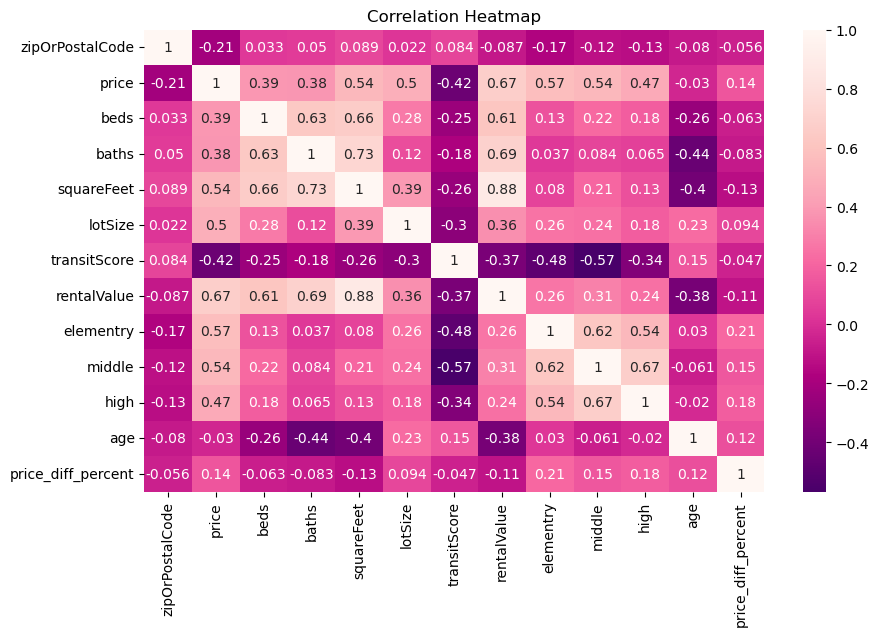

In [578]:
# Heatmap plot on encodedData correlation
plt.figure(figsize=(10, 6))
sns.heatmap(finalHouseDf2.corr(numeric_only=True), annot=True, cmap='RdPu_r')
plt.title('Correlation Heatmap')
plt.show()

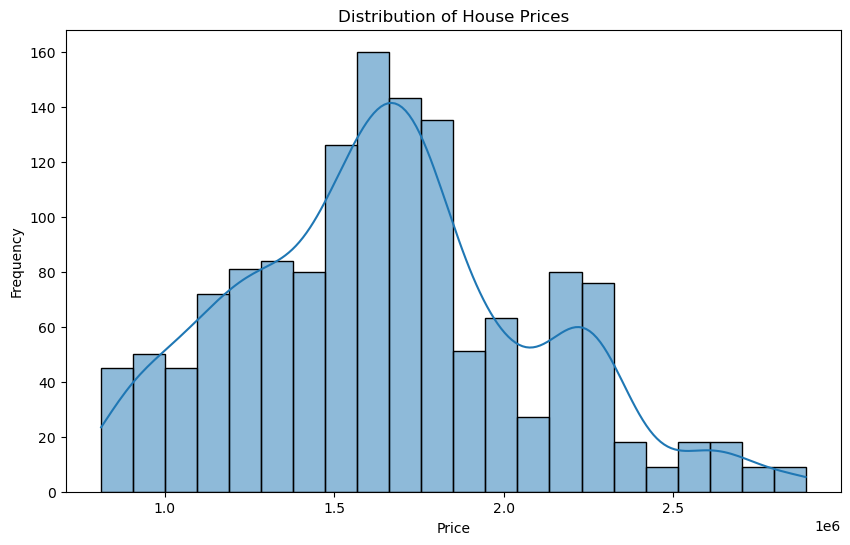

In [551]:
# Lets see how the House prices are distributed
plt.figure(figsize=(10, 6))
sns.histplot(newHouseDf['price'], kde=True)
plt.title('Distribution of House Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

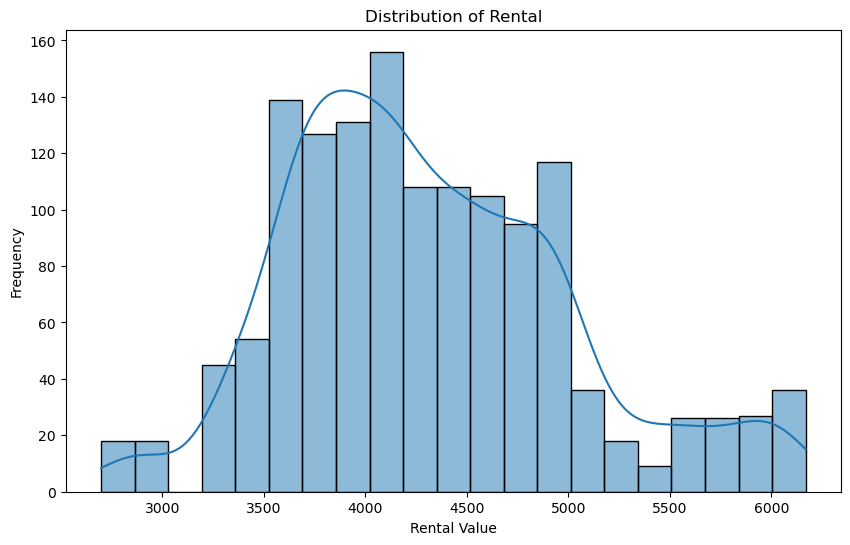

In [552]:
# Lets see how the Rental values are distributed
plt.figure(figsize=(10, 6))
sns.histplot(newHouseDf['rentalValue'], kde=True)
plt.title('Distribution of Rental')
plt.xlabel('Rental Value')
plt.ylabel('Frequency')
plt.show()

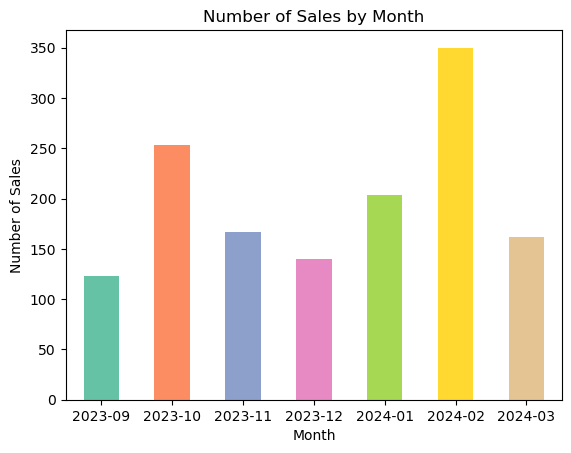

In [553]:
# Bar plot of Number of Sales each month

sales_by_month = newHouseDf.groupby('soldDate').size()
sales_by_month.plot(kind='bar', xlabel='Month', ylabel='Number of Sales', title='Number of Sales by Month',color=colorSet2)
plt.xticks(rotation=0)
plt.show()

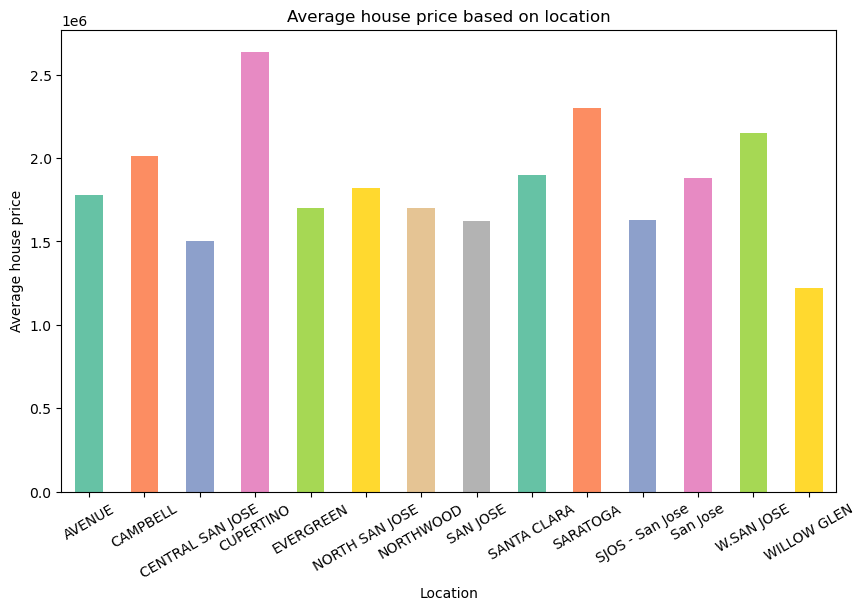

In [554]:
# Bar plot of Number of Sales each month
plt.figure(figsize=(10, 6))
sales_by_month = newHouseDf.groupby('location')['price'].mean()
sales_by_month
sales_by_month.plot(kind='bar', xlabel='Location', ylabel='Average house price', title='Average house price based on location',color=colorSet2)
plt.xticks(rotation=30)
plt.show()

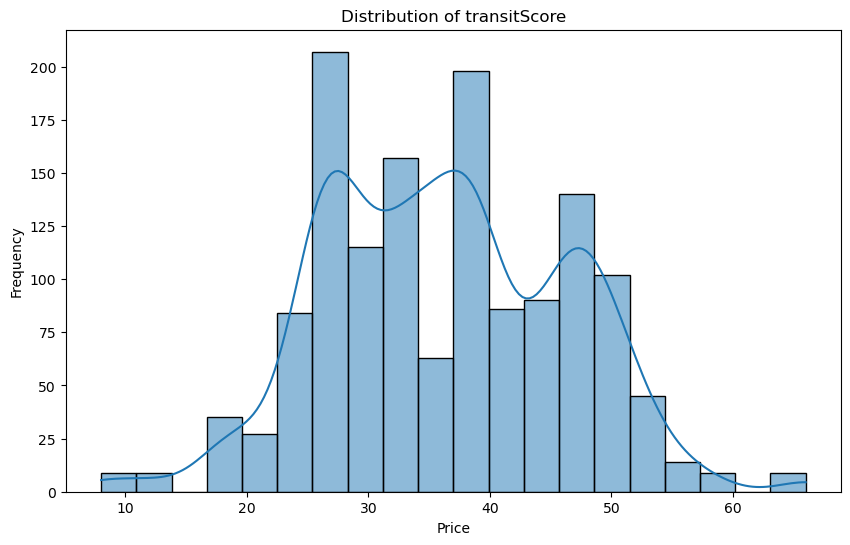

In [555]:
# Lets see how the transitScore are distributed
plt.figure(figsize=(10, 6))
sns.histplot(newHouseDf['transitScore'], kde=True)
plt.title('Distribution of transitScore')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

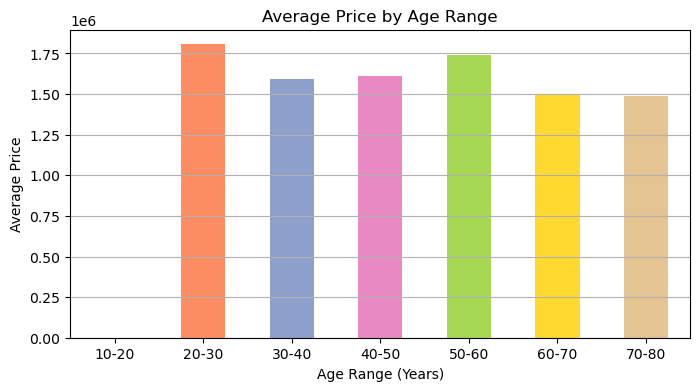

In [556]:
#Bar Plot for age range vs average price
bins = [20, 30, 40, 50, 60, 70, 80, 90] 
wowDf = newHouseDf.copy()
# Bin the 'age' column into age ranges and calculate avg price
wowDf['age_range'] = pd.cut(wowDf['age'], bins=bins, labels=['10-20', '20-30', '30-40', '40-50',
                                                             '50-60', '60-70', '70-80'])
avg_price_by_age_range = wowDf.groupby('age_range')['price'].mean()

# Plot age range vs average price
plt.figure(figsize=(8, 4))
avg_price_by_age_range.plot(kind='bar', color=colorSet2)
plt.title('Average Price by Age Range')
plt.xlabel('Age Range (Years)')
plt.ylabel('Average Price')
plt.grid(axis='y')
plt.xticks(rotation=0)
plt.show()

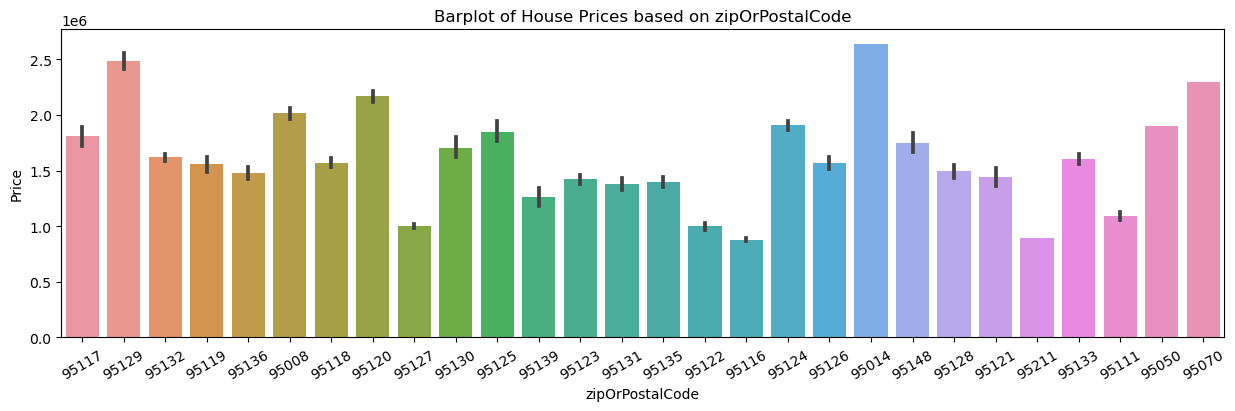

In [557]:
#Barplot of House Prices based on zipOrPostalCode
plt.figure(figsize=(15, 4))
sns.barplot(x='zipOrPostalCode', y='price', data=newHouseDf)
plt.title('Barplot of House Prices based on zipOrPostalCode')
plt.xlabel('zipOrPostalCode')
plt.ylabel('Price')
plt.xticks(rotation=30)
plt.show()

In [558]:
#Remove SoldDate, location, zipOrPostalCode from DF to run PCA
finDf2 = newHouseDf.drop(['soldDate', 'location', 'zipOrPostalCode'], axis=1)
finDf2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1399 entries, 0 to 2625
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price               1399 non-null   float64
 1   beds                1399 non-null   float64
 2   baths               1399 non-null   float64
 3   squareFeet          1399 non-null   float64
 4   lotSize             1399 non-null   float64
 5   yearBuilt           1399 non-null   float64
 6   ppsf                1399 non-null   float64
 7   walkScore           1399 non-null   float64
 8   bikeScore           1399 non-null   float64
 9   transitScore        1399 non-null   float64
 10  rentalValue         1399 non-null   float64
 11  elementry           1399 non-null   float64
 12  middle              1399 non-null   float64
 13  high                1399 non-null   float64
 14  listPrice           1399 non-null   float64
 15  age                 1399 non-null   float64
 16  price_

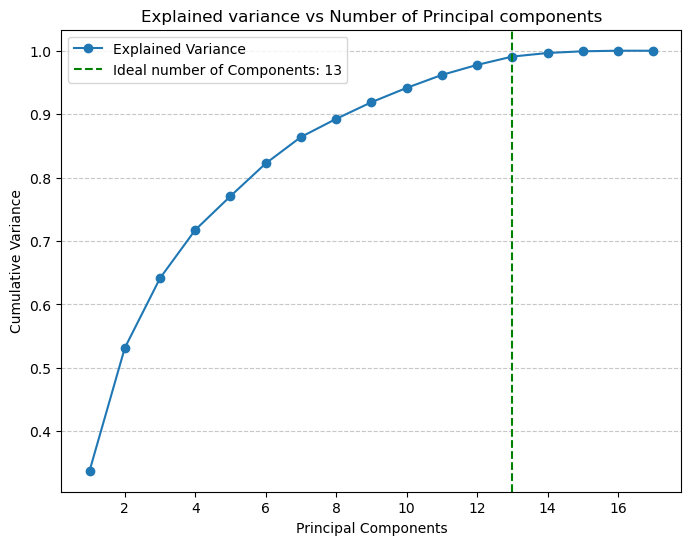

Number of components to keep: 13


In [559]:
from sklearn.decomposition import PCA
# Running PCA for idea feature selection
#normalize data
scaledDf = (finDf2 - finDf2.mean()) / finDf2.std()

numeric_data = scaledDf.select_dtypes(include=[np.number])
# Standardize the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

#initialize PCA and fit data
pca = PCA()
pca.fit(scaled_data)
cum_var =  np.cumsum(pca.explained_variance_ratio_)

#plot the explained variance
fig, ax1 = plt.subplots(figsize=(8, 6))
ax1.plot(range(1, len(cum_var) + 1), cum_var, '-o', label='Explained Variance')
ax1.set_xlabel('Principal Components')
ax1.set_ylabel('Cumulative Variance')
ax1.set_title('Explained variance vs Number of Principal components')
ax1.grid(axis='y', linestyle='--', alpha=0.7)
threshold = 0.99
n_components = np.argmax(cum_var >= threshold) + 1
ax1.axvline(x=n_components, color='green', linestyle='--', label=f'Ideal number of Components: {n_components}')
ax1.legend()
plt.show()

print(f"Number of components to keep: {n_components}")

In [579]:
# Need to remove 6 columns from 17 to 11
finalHouseDf2 = finalHouseDf.drop([ 'ppsf', 'yearBuilt','location', 'listPrice', 'walkScore', 'bikeScore'], axis=1)
finalHouseDf2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1732 entries, 0 to 2625
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   zipOrPostalCode     1732 non-null   float64
 1   price               1732 non-null   float64
 2   beds                1732 non-null   float64
 3   baths               1732 non-null   float64
 4   squareFeet          1732 non-null   float64
 5   lotSize             1732 non-null   float64
 6   transitScore        1732 non-null   float64
 7   rentalValue         1732 non-null   float64
 8   elementry           1732 non-null   float64
 9   middle              1732 non-null   float64
 10  high                1732 non-null   float64
 11  age                 1732 non-null   float64
 12  price_diff_percent  1732 non-null   float64
dtypes: float64(13)
memory usage: 189.4 KB


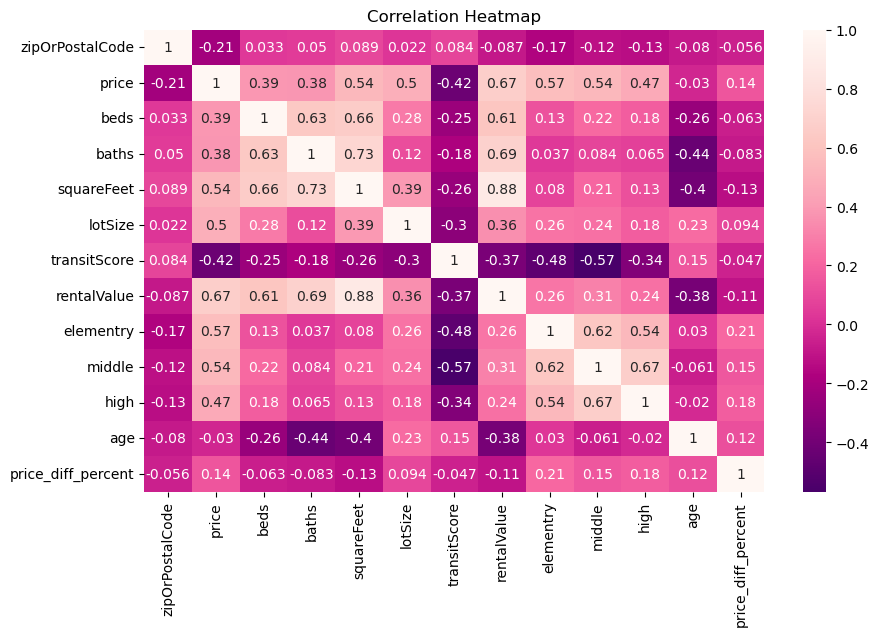

In [561]:
# Heatmap plot on encodedData correlation
plt.figure(figsize=(10, 6))
sns.heatmap(finalHouseDf2.corr(numeric_only=True), annot=True, cmap='RdPu_r')
plt.title('Correlation Heatmap')
plt.show()

### Modeling

Get X and y from the finalHouseDf2
Split the data for cross-validation. 
Extract numeric and categorical features.
Create numeric and categorical tranformers

Create pipeline with Gradient boost, Random forest regressor, Ridge Regression and SVR. 
Choose hyoerparameters for above model. 
Run the GridSearchCv, calculate the R2score, MSE, MAE and average fit time. 

In [570]:
#This would be common for all regression models and enseble methods
X = finalHouseDf2.drop('price', axis=1)
y = finalHouseDf2['price']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define transformers for numerical and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, numeric_features),
        ('categorical', categorical_transformer, categorical_features)
    ])

In [563]:
#common function to run different models
def evaluate_model(model_pipe, params_grid, name):
    grid_search = GridSearchCV(model_pipe, params_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    
    start_time = time.time()
    #Fit the grid_search with training dataset
    grid_search.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    best_model = grid_search.best_estimator_
    print(f'Best model {best_model[1]}')
    #predict churn for the test dataset
    test_preds = best_model.predict(X_test)
    train_preds = best_model.predict(X_train)
    
    
    result_dict = pd.DataFrame({
        'Name'             : [name],
        'Train MAE'        : [mean_absolute_error(y_train, train_preds)],
        'Test MAE'         : [mean_absolute_error(y_test, test_preds)],
        'Train MSE'        : [mean_squared_error(y_train, train_preds)],
        'Test MSE'         : [mean_squared_error(y_test, test_preds)],
        'Train R2-score'   : [r2_score(y_train, train_preds)],
        'Test R2-score'    : [r2_score(y_test, test_preds)],
        'Average Fit Time' : [grid_search.cv_results_['mean_fit_time'].mean()],
    })
    #Extract feature importance
    perm_importance = permutation_importance(grid_search, X_test, y_test, n_repeats=30, random_state=42)
    feature_importance = pd.DataFrame({'Feature': X_test.columns, 'Importance': perm_importance.importances_mean})
    featureSorted = feature_importance.sort_values(by='Importance', ascending=False)
    return (result_dict, featureSorted)

Best model GradientBoostingRegressor(learning_rate=0.2, max_depth=7, n_estimators=50)


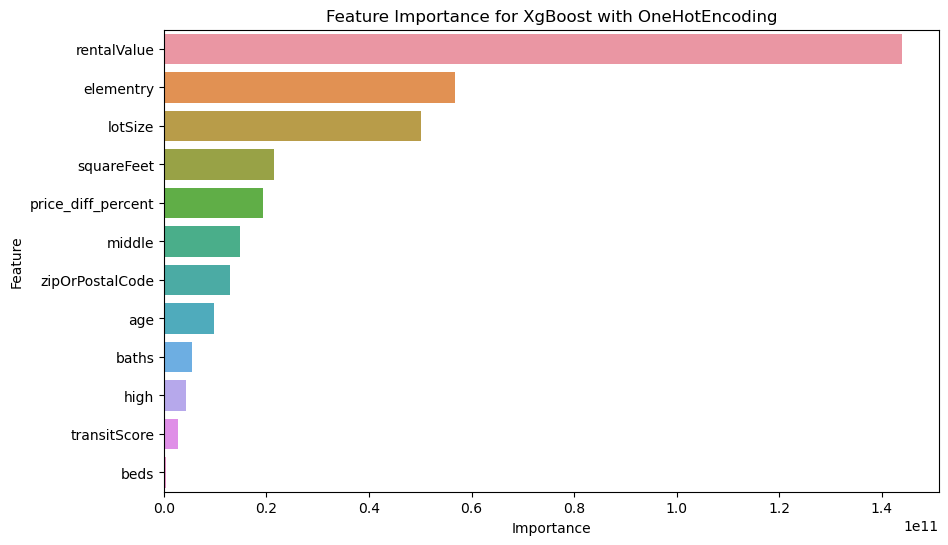

,Name,Train MAE,Test MAE,Train MSE,Test MSE,Train R2-score,Test R2-score,Average Fit Time
0,Gradient Boosting Regressor,346.81,1396.38,216404.54,168323920.85,1.00,1.00,0.36


In [564]:
# Create a pipeline with the preprocessor and Gradient Boosting Regressor
xg_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', GradientBoostingRegressor())])

# Define the parameter grid for GridSearchCV
xg_param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__learning_rate': [0.05, 0.1, 0.2],
    'regressor__max_depth': [3, 5, 7]
}

#Run gridSearchCv
(xg_df, xg_perm_importance) = evaluate_model(xg_pipeline, xg_param_grid, "Gradient Boosting Regressor")

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(xg_perm_importance, y= 'Feature', x= 'Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for XgBoost with OneHotEncoding')
plt.show()

xg_df

Best model RandomForestRegressor(max_depth=20, n_estimators=300)


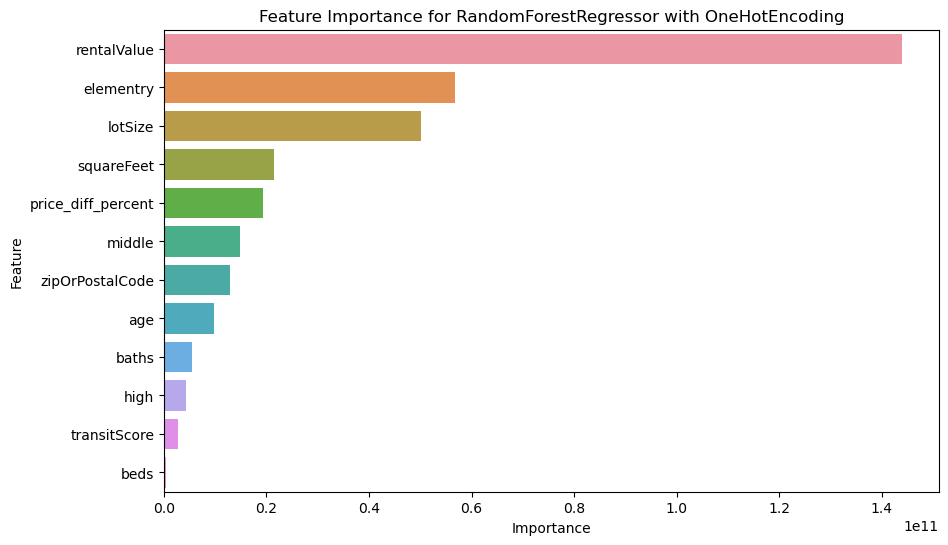

,Name,Train MAE,Test MAE,Train MSE,Test MSE,Train R2-score,Test R2-score,Average Fit Time
0,Random Forest Regressor,784.48,2464.58,10666860.87,68075673.09,1.00,1.00,0.88


In [565]:
# Create a pipeline with the preprocessor and Random Forest Regressor
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', RandomForestRegressor())])

# Define the parameter grid for GridSearchCV
rf_param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [10, 20, 30],
}
#Run gridSearchCv
(rf_df, rf_perm_importance) = evaluate_model(rf_pipeline, rf_param_grid, "Random Forest Regressor")
rf_df

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(xg_perm_importance, y= 'Feature', x= 'Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for RandomForestRegressor with OneHotEncoding')
plt.show()

rf_df

Best model Ridge(alpha=10.0)


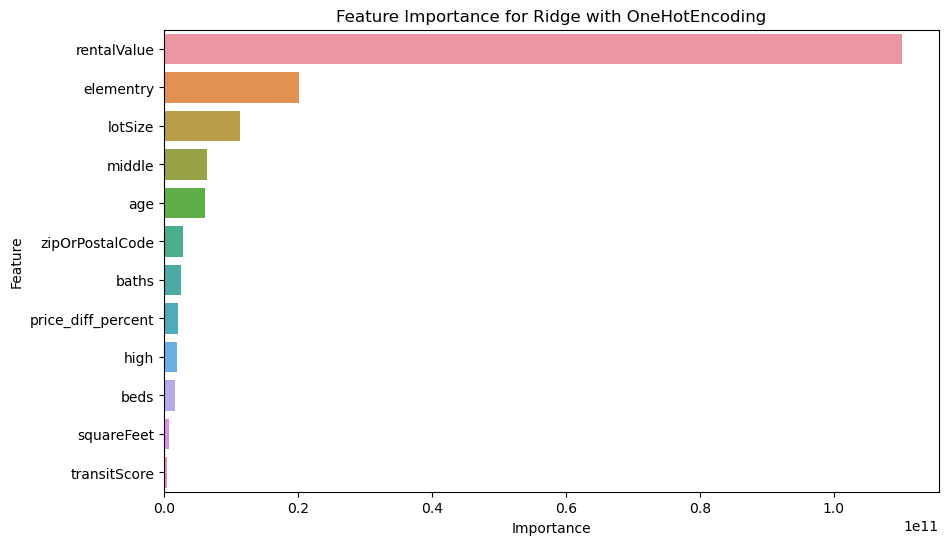

,Name,Train MAE,Test MAE,Train MSE,Test MSE,Train R2-score,Test R2-score,Average Fit Time
0,Ridge Regressor,180989.70,183148.98,55462147584.32,56921692835.95,0.72,0.71,0.01


In [566]:
# Create a pipeline with the preprocessor and Ridge Regressor
ridge_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', Ridge())])

# Define hyperparameters for grid search
ridge_param_grid = {
    'regressor__alpha':  [0.001, 0.01, 0.1, 1.0, 10.0]
}

xg_df
(ridge_df, ridge_perm_importance) = evaluate_model(ridge_pipeline, ridge_param_grid, "Ridge Regressor")


# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(ridge_perm_importance, y= 'Feature', x= 'Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Ridge with OneHotEncoding')
plt.show()

ridge_df

Best model SVR(C=10, epsilon=1, kernel='linear')


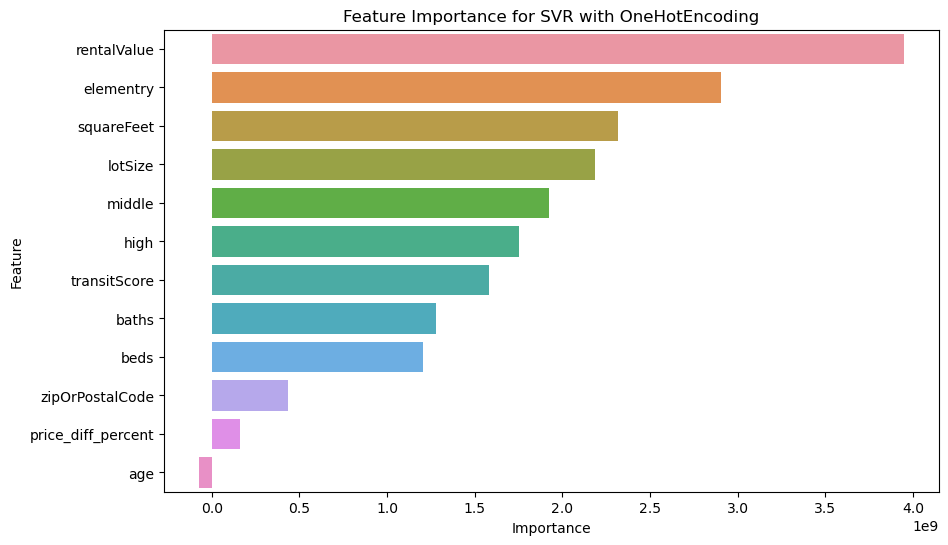

,Name,Train MAE,Test MAE,Train MSE,Test MSE,Train R2-score,Test R2-score,Average Fit Time
0,Support Vector Regressor,339513.08,342535.13,178453347585.24,174158549203.11,0.09,0.10,0.07


In [567]:
svr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', SVR())])

svr_param_grid = {
    'regressor__kernel': ['linear', 'rbf', 'poly'],
    'regressor__C': [0.1, 1, 10],
    'regressor__epsilon': [0.01, 0.1, 1]
}

xg_df
(svr_df, svr_perm_importance) = evaluate_model(svr_pipeline, svr_param_grid, "Support Vector Regressor")


# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(svr_perm_importance, y= 'Feature', x= 'Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for SVR with OneHotEncoding')
plt.show()

svr_df

In [581]:
#Concat all data
resultDf = pd.concat([ridge_df, rf_df, svr_df, xg_df])

# Set the display format
pd.options.display.float_format = '{:.2f}'.format
resultDf = resultDf.reset_index()
def highlight_max_float64(s):
    is_float = s.dtype == 'float64'
    return ['background-color: lightgreen' if is_float and v == s.min() else '' for v in s]

resultDf.style.apply(highlight_max_float64)

,index,Name,Train MAE,Test MAE,Train MSE,Test MSE,Train R2-score,Test R2-score,Average Fit Time
0,0,Ridge Regressor,180989.698180,183148.975769,55462147584.315254,56921692835.949097,0.718730,0.705945,0.007507
1,0,Random Forest Regressor,784.483782,2464.582724,10666860.865379,68075673.088015,0.999946,0.999648,0.877492
2,0,Support Vector Regressor,339513.083432,342535.133932,178453347585.237274,174158549203.112183,0.094993,0.100305,0.070945
3,0,Gradient Boosting Regressor,346.805758,1396.383013,216404.538094,168323920.851694,0.999999,0.999130,0.362793


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

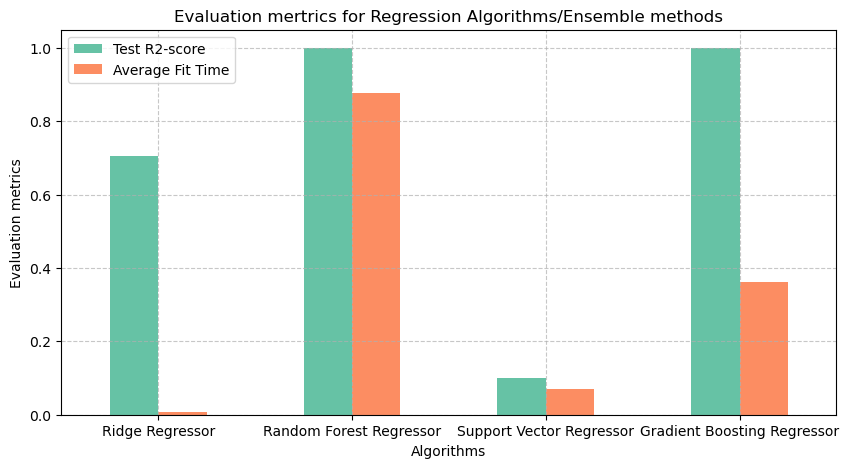

In [569]:
resultDf.plot(x="Name", y=["Test R2-score", "Average Fit Time"],
        kind="bar", figsize=(10, 5), color=colorSet2)
plt.title("Evaluation mertrics for Regression Algorithms/Ensemble methods")
plt.xlabel("Algorithms")
plt.ylabel("Evaluation metrics")
plt.xticks(rotation=0)
plt.grid(alpha=0.7,  linestyle='--')
plt.show()

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

From above observatuons it is evident that ensemble methods are better when performing the predictions. 
Gradient boost and Random Forest works best with highest R2 score. Random forest regressor takes longer than Gradient boost. Based on the train and test MSE, we can see that there is overfitting. Need to revisit the dataset and hyper parameter tuning to get better results. 